In [61]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import  metrics  


from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier


from scipy import stats

import xgboost as xgb


%matplotlib inline
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [62]:
train = pd.read_csv("output/new_data.csv")
train.drop("Unnamed: 0", axis = 1, inplace = True)
#train2 = pd.read_csv("input/beers.csv")
test = pd.read_csv("input/beers_test_nostyle.csv")


In [63]:
#trying mixed data
#train2.drop("UserId", axis = 1, inplace = True)
#train2.drop("Name", axis = 1, inplace = True)
#train2.drop("PitchRate", axis = 1, inplace = True)
#train2.drop("Efficiency", axis = 1, inplace = True)

In [64]:
#train = pd.concat([train1, train2], axis=0)

In [65]:
print("The train data size before dropping UserId feature is : {} ".format(train.shape))
print("The test data size before dropping UserId feature is : {} ".format(test.shape))

#Now drop the  'UserId' colum since it's unnecessary for  the prediction process.
#train.drop("UserId", axis = 1, inplace = True)
test.drop("UserId", axis = 1, inplace = True)

#check again the data size after dropping the 'UserId' variable
print("\nThe train data size after dropping UserId feature is : {} ".format(train.shape)) 
print("The test data size after dropping UserId feature is : {} ".format(test.shape))

The train data size before dropping UserId feature is : (52376, 8) 
The test data size before dropping UserId feature is : (10713, 11) 

The train data size after dropping UserId feature is : (52376, 8) 
The test data size after dropping UserId feature is : (10713, 10) 


In [66]:
#Unecessary for model training
#train.drop("Name", axis = 1, inplace = True)

In [67]:
#Style mapping to the discrete values
#styles = train["Style"].unique()
#style_n_labels = [i+1 for i in range(len(train["Style"].unique()))]
#styles_mapping = dict(zip(styles,  [i+1 for i in range(len(styles))]))
#train["Style"] = train["Style"].map(styles_mapping)

In [68]:
for col in train.columns.values:
    null_priming = train[col].isnull()
    print('{} is null on {} rows out of {}, so {} % of the time'.format(col, null_priming.sum(), len(train), round((null_priming.sum()/len(train))*100,2)))

Style is null on 0 rows out of 52376, so 0.0 % of the time
OG is null on 0 rows out of 52376, so 0.0 % of the time
FG is null on 0 rows out of 52376, so 0.0 % of the time
ABV is null on 0 rows out of 52376, so 0.0 % of the time
IBU is null on 0 rows out of 52376, so 0.0 % of the time
Color is null on 0 rows out of 52376, so 0.0 % of the time
BoilTime is null on 0 rows out of 52376, so 0.0 % of the time
BoilGravity is null on 0 rows out of 52376, so 0.0 % of the time


In [69]:
for col in test.columns.values:
    
    null_priming = test[col].isnull()
    print('{} is null on {} rows out of {}, so {} % of the time'.format(col, null_priming.sum(), len(test), round((null_priming.sum()/len(test))*100,2)))

Id is null on 0 rows out of 10713, so 0.0 % of the time
OG is null on 0 rows out of 10713, so 0.0 % of the time
FG is null on 0 rows out of 10713, so 0.0 % of the time
ABV is null on 0 rows out of 10713, so 0.0 % of the time
IBU is null on 0 rows out of 10713, so 0.0 % of the time
Color is null on 0 rows out of 10713, so 0.0 % of the time
BoilTime is null on 0 rows out of 10713, so 0.0 % of the time
BoilGravity is null on 366 rows out of 10713, so 3.42 % of the time
PitchRate is null on 5760 rows out of 10713, so 53.77 % of the time
Efficiency is null on 0 rows out of 10713, so 0.0 % of the time


In [70]:
#52% is too much noise in the dataset, let's ignore it
#train.drop("PitchRate", axis = 1, inplace = True)
test.drop("PitchRate", axis = 1, inplace = True)

In [71]:
train.head()

,Style,OG,FG,ABV,IBU,Color,BoilTime,BoilGravity
0,Witbier,1.051,1.012,5.220,18.670,3.670,60,1.035
1,Witbier,1.057,1.012,5.870,23.210,3.110,90,1.041
2,Witbier,1.050,1.013,4.850,20.080,3.330,90,1.037
3,Witbier,1.052,1.013,5.220,16.790,4.310,90,1.044
4,Witbier,1.052,1.011,5.360,18.920,3.260,90,1.041


In [72]:
test.head()

,Id,OG,FG,ABV,IBU,Color,BoilTime,BoilGravity,Efficiency
0,0,1.046,1.011,4.660,16.870,27.470,60,1.033,75.000
1,1,1.065,1.014,6.770,39.140,18.720,90,1.043,55.000
2,2,1.081,1.020,7.980,67.590,39.450,60,1.068,72.000
3,3,1.054,1.012,5.490,38.550,37.090,60,1.045,80.000
4,4,1.044,1.008,4.690,31.780,7.760,60,1.044,35.000


ValueError: could not convert string to float: 'Witbier'

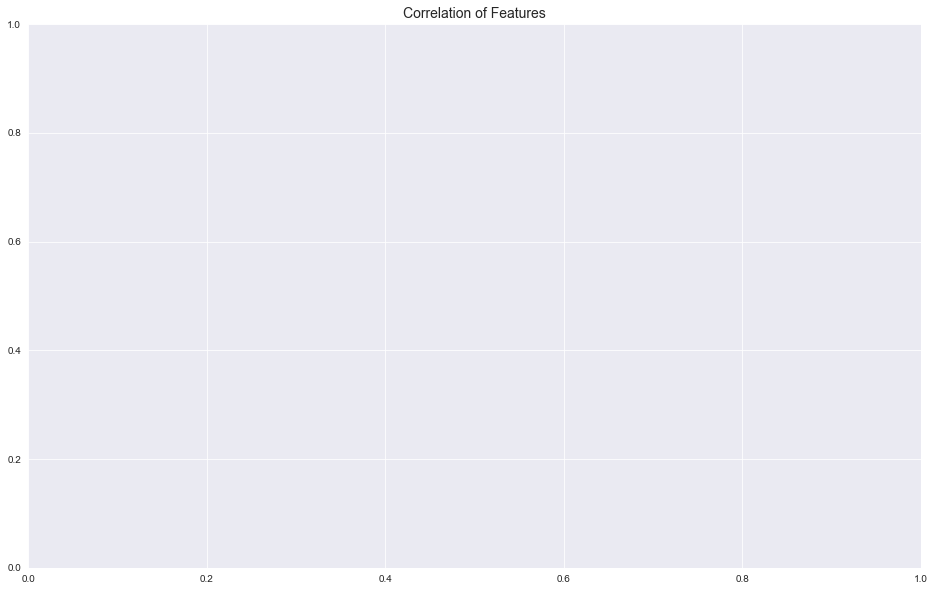

In [77]:
colormap = plt.cm.RdBu
plt.figure(figsize=(16,10))
plt.title('Correlation of Features', y=1.0, size=14)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


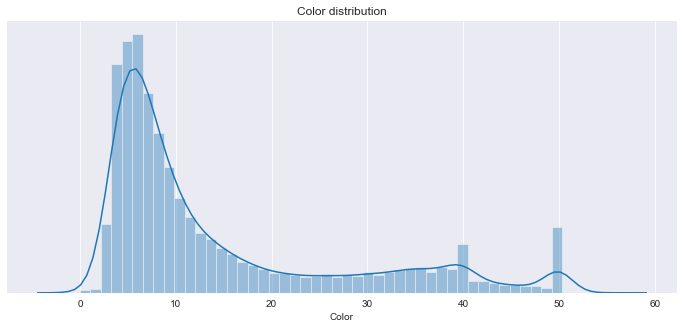

In [83]:
fig, ax = plt.subplots(1, 1, figsize=[12,5])
sns.distplot(train['Color'], ax=ax)
ax.set_title('Color distribution')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

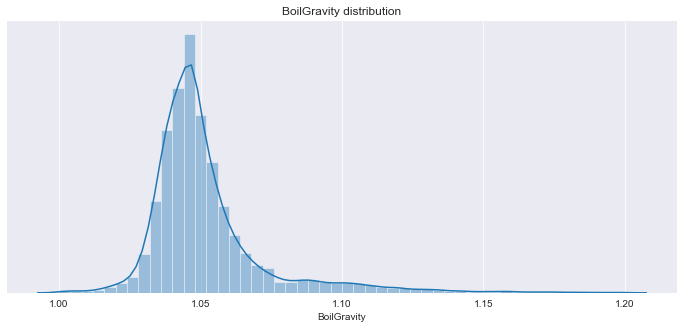

In [47]:
fig, ax = plt.subplots(1, 1, figsize=[12,5])
sns.distplot(train['BoilGravity'], ax=ax)
ax.set_title('BoilGravity distribution')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [48]:
train.describe()

,OG,FG,ABV,IBU,Color,BoilTime,BoilGravity
count,40503.000,40503.000,40503.000,40503.000,40503.000,40503.000,40503.000
mean,1.059,1.013,6.026,48.515,8.617,64.383,1.052
std,0.013,0.004,1.352,32.827,4.921,12.814,0.021
min,1.000,0.999,0.000,0.000,0.000,0.000,1.000
25%,1.051,1.010,5.150,26.410,5.070,60.000,1.040
50%,1.057,1.013,5.860,40.910,7.100,60.000,1.047
75%,1.066,1.016,6.730,63.870,10.750,60.000,1.056
max,1.142,1.067,14.880,224.920,25.000,240.000,1.200


In [82]:
#deleting outliers
train = train[train['ABV'] <= 15]
train = train[train['IBU'] <= 225]
train = train[train['OG'] <= 1.150]
train = train[train['BoilGravity'] <= 1.2]
train = train[train['Color'] <=55 ]
#train['Color'].describe()

In [50]:
train.fillna(train['BoilGravity'].median(), inplace=True)
test.fillna(test['BoilGravity'].median(), inplace=True)

In [51]:
#train["Color^3"] = train["Color"] ** 2
#train["IBU^3"] = train["IBU"] ** 2
#train["FG^3"] = train["FG"] ** 3

In [52]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["Style"], ascending = False, inplace = True)
corr.Style

Find most important features relative to target


KeyError: 'Style'

In [84]:
#train.drop("Efficiency", axis = 1, inplace = True)
test.drop("Efficiency", axis = 1, inplace = True)

In [85]:
#gravity change may be done as one parameter
#train['gravity_change'] = train['OG'] - train['FG']
#test['gravity_change'] = test['OG'] - test['FG']
#train.drop("OG", axis = 1, inplace = True)
#test.drop("OG", axis = 1, inplace = True)
#train.drop("FG", axis = 1, inplace = True)
#test.drop("FG", axis = 1, inplace = True)

In [86]:
X = train.drop("Style", axis = 1)
Y = train["Style"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)

In [87]:
test_Id = test['Id']
test.drop("Id", axis=1, inplace=True)

In [88]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [89]:
#Stochastic gradient descent
sgd = SGDClassifier(max_iter=10000, tol=1e-3, penalty=None)
sgd.fit(X_train, y_train)
sgd_pred = sgd.predict(X_test)
print(classification_report(y_test, sgd_pred))

              precision    recall  f1-score   support

         Ale       0.59      0.69      0.63      1879
         IPA       0.68      0.83      0.75      1593
       Lager       0.00      0.00      0.00       376
      Porter       0.35      0.02      0.04       261
      Saison       0.00      0.00      0.00       249
       Stout       0.60      0.89      0.72       583
     Witbier       0.00      0.00      0.00       110

    accuracy                           0.62      5051
   macro avg       0.32      0.35      0.31      5051
weighted avg       0.52      0.62      0.56      5051



In [ ]:
#SVC
svc =  SVC(gamma='auto')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print(classification_report(y_test, svc_pred))

In [ ]:
#GridSearchCV
parameters = {
    'kernel':('linear', 'rbf'),
    'C':[0.1, 0.2, 0.4, 0.8, 0.9, 1.1, 1.4],
}
grid_svc = GridSearchCV(svc, param_grid=parameters, scoring='accuracy', cv=10)
grid_svc.fit(X_train, y_train)

In [ ]:
grid_svc.best_params_

In [77]:
#SVC after grid svc //NEW RESULT
svc2 = SVC(C=1.4, gamma="auto", kernel = 'rbf')
svc2.fit(X_train, y_train)
svc2_pred = svc2.predict(X_test)
print(classification_report(y_test, svc2_pred))

              precision    recall  f1-score   support

         Ale       0.61      0.82      0.70      3662
         IPA       0.77      0.80      0.79      3234
       Lager       0.69      0.05      0.09       795
      Porter       0.45      0.25      0.33       492
      Saison       0.73      0.08      0.15       532
       Stout       0.70      0.85      0.77      1177
     Witbier       0.00      0.00      0.00       212

    accuracy                           0.67     10104
   macro avg       0.56      0.41      0.40     10104
weighted avg       0.66      0.67      0.63     10104



In [90]:
#RandomForest /1ver
rfc = RandomForestClassifier(n_estimators=50, min_samples_split= 8,criterion="entropy", max_depth=8)
rfc.fit(X_train, y_train)
rfc_pred= rfc.predict(X_test)
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

         Ale       0.63      0.81      0.71      1879
         IPA       0.76      0.78      0.77      1593
       Lager       0.70      0.09      0.15       376
      Porter       0.46      0.19      0.27       261
      Saison       0.60      0.11      0.19       249
       Stout       0.66      0.89      0.76       583
     Witbier       1.00      0.04      0.07       110

    accuracy                           0.67      5051
   macro avg       0.69      0.41      0.42      5051
weighted avg       0.68      0.67      0.63      5051



In [60]:
#RandomForest /2ver
rfc = RandomForestClassifier(n_estimators=500, min_samples_split= 1000,criterion="entropy", max_depth=8)
rfc.fit(X_train, y_train)
rfc_pred= rfc.predict(X_test)
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

         Ale       0.58      0.85      0.69      1705
         IPA       0.79      0.79      0.79      1538
       Lager       0.73      0.07      0.12       360
      Porter       0.00      0.00      0.00        33
      Saison       0.50      0.00      0.01       280
       Stout       0.00      0.00      0.00        16
     Witbier       0.00      0.00      0.00       119

    accuracy                           0.66      4051
   macro avg       0.37      0.24      0.23      4051
weighted avg       0.65      0.66      0.60      4051



In [82]:
xgbc = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=6,
 gamma=0.01,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgbc.fit(X_train, y_train)
xgbc_pred= xgbc.predict(X_test)
print(classification_report(y_test, xgbc_pred))

              precision    recall  f1-score   support

         Ale       0.67      0.76      0.71      3662
         IPA       0.76      0.81      0.78      3234
       Lager       0.54      0.19      0.29       795
      Porter       0.43      0.34      0.38       492
      Saison       0.49      0.27      0.35       532
       Stout       0.70      0.80      0.75      1177
     Witbier       0.56      0.45      0.50       212

    accuracy                           0.68     10104
   macro avg       0.59      0.52      0.54     10104
weighted avg       0.67      0.68      0.66     10104



In [83]:
xgbc = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgbc.fit(X_train, y_train)
xgbc_pred= xgbc.predict(X_test)
print(classification_report(y_test, xgbc_pred))

              precision    recall  f1-score   support

         Ale       0.66      0.76      0.71      3662
         IPA       0.76      0.81      0.79      3234
       Lager       0.53      0.18      0.27       795
      Porter       0.46      0.36      0.40       492
      Saison       0.52      0.28      0.36       532
       Stout       0.71      0.81      0.76      1177
     Witbier       0.55      0.44      0.49       212

    accuracy                           0.69     10104
   macro avg       0.60      0.52      0.54     10104
weighted avg       0.67      0.69      0.67     10104



In [ ]:
#logistic Regression clf // NEW RESULTS
lrc = LogisticRegression()
lrc.fit(X_train, y_train)
lrc_pred= lrc.predict(X_test)
print(classification_report(y_test, lrc_pred))

In [86]:
#KNN classifier //NEW RESULTS
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train, y_train)
knn_pred= knn.predict(X_test)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

         Ale       0.64      0.77      0.69      3662
         IPA       0.76      0.79      0.78      3234
       Lager       0.46      0.13      0.21       795
      Porter       0.44      0.37      0.40       492
      Saison       0.49      0.23      0.31       532
       Stout       0.72      0.80      0.76      1177
     Witbier       0.50      0.31      0.38       212

    accuracy                           0.67     10104
   macro avg       0.57      0.48      0.50     10104
weighted avg       0.65      0.67      0.65     10104



In [87]:
test = sc.fit_transform(test)

y_pred = xgbc.predict(test)

In [88]:
np.unique(y_pred)

array(['Ale', 'IPA', 'Lager', 'Porter', 'Saison', 'Stout', 'Witbier'],
      dtype=object)

In [89]:
submission = pd.DataFrame({
        "Id": test_Id,
        "Style": y_pred
    })

In [90]:
submission.to_csv('output/submission.csv', index=False)

In [91]:
submission.shape

(10713, 2)